Installing the Libraries

In [ ]:
!pip install scikit-learn
!python -c "import sklearn; print(sklearn.__version__)"

1.5.2


Importing neccesary Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import os


Now,here I taken an example of real world problem (Satellite Imaginary) by using Eurostat dataset to explain the concept of Pseudo-Labelling.

Step 1:Load and preprocess the EuroSAT dataset

In [ ]:
#Load EuroSAT dataset
from tensorflow.keras.utils import get_file
dataset_url = "http://madm.dfki.de/files/sentinel/EuroSAT.zip"
dataset_path = get_file("EuroSAT", dataset_url, extract=True)
base_dir = os.path.join(os.path.dirname(dataset_path), "2750")

In [ ]:
# Data preprocessing and augmentation
data_augmentation = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [ ]:
# Load dataset into memory
data_flow = data_augmentation.flow_from_directory(
    base_dir,
    target_size=(64, 64),
    class_mode="sparse",
    batch_size=10000
)
images, labels = next(data_flow)

Found 27000 images belonging to 10 classes.


In [ ]:
# Split the dataset into labeled and unlabeled sets
X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(
    images, labels, test_size=0.9, random_state=42
)


In [ ]:
print(f"X-Labeled data shape: {X_labeled.shape}")
print(f"X-Unlabeled data shape: {X_unlabeled.shape}")


X-Labeled data shape: (1000, 64, 64, 3)
X-Unlabeled data shape: (9000, 64, 64, 3)


In [ ]:
# Split labeled data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Unlabeled set: {X_unlabeled.shape}")


Training set: (800, 64, 64, 3), Validation set: (200, 64, 64, 3), Unlabeled set: (9000, 64, 64, 3)



### Step 2: Define the CNN model

In [ ]:
#define the CNN model
def build_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')  # 10 classes for EuroSAT
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


Step 3: Train the model on the labeled dataset

In [ ]:
#Train the model on the labeled dataset
model = build_model()
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=5,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 302ms/step - accuracy: 0.1221 - loss: 2.3227 - val_accuracy: 0.2250 - val_loss: 2.0783
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 0.2429 - loss: 2.0722 - val_accuracy: 0.3050 - val_loss: 1.8996
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - accuracy: 0.2583 - loss: 1.9797 - val_accuracy: 0.3450 - val_loss: 1.7863
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 221ms/step - accuracy: 0.2596 - loss: 1.8626 - val_accuracy: 0.3900 - val_loss: 1.6533
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 315ms/step - accuracy: 0.3279 - loss: 1.7419 - val_accuracy: 0.4100 - val_loss: 1.6200


In [ ]:
# Evaluate initial accuracy
initial_predictions = model.predict(X_labeled)
initial_accuracy = accuracy_score(y_labeled, np.argmax(initial_predictions, axis=1))
print(f"Initial model accuracy: {initial_accuracy * 100:.2f}%")


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
Initial model accuracy: 41.00%


### Step 4: Pseudo-labeling

In [ ]:
#Pseudo-labeling
unlabeled_predictions = model.predict(X_unlabeled)
pseudo_labels = np.argmax(unlabeled_predictions, axis=1)
confidence_scores = np.max(unlabeled_predictions, axis=1)

282/282 ━━━━━━━━━━━━━━━━━━━━ 22s 79ms/step


In [ ]:
# Print confidence scores to debug
print(f"Confidence scores for unlabeled data: {confidence_scores[:10]}")  # Print first 10 for verification


Confidence scores for unlabeled data: [0.47233215 0.16687393 0.15823147 0.12675208 0.25900862 0.19189814
 0.5018306  0.49164623 0.2535158  0.21801755]


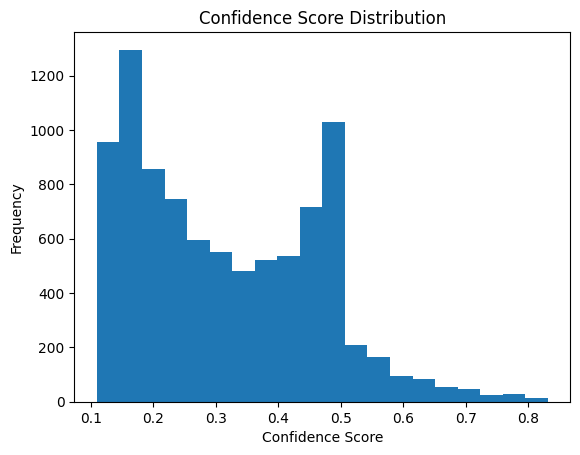

In [ ]:
plt.hist(confidence_scores, bins=20)
plt.title('Confidence Score Distribution')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# Set confidence threshold (lowered to 0.8 for more samples)
confidence_threshold = 0.6
high_confidence_indices = np.where(confidence_scores >= confidence_threshold)[0]


In [ ]:
# Filter pseudo-labeled data
X_pseudo = X_unlabeled[high_confidence_indices]
y_pseudo = pseudo_labels[high_confidence_indices]
print(f"Pseudo-labeled data added: {len(X_pseudo)} samples")

Pseudo-labeled data added: 287 samples


### Step 5: Retrain the model with augmented labeled and pseudo-labeled data

In [ ]:
#Retrain the model with augmented labeled and pseudo-labeled data
X_augmented = np.concatenate((X_labeled, X_pseudo))
y_augmented = np.concatenate((y_labeled, y_pseudo))

X_train_aug, X_val_aug, y_train_aug, y_val_aug = train_test_split(
    X_augmented, y_augmented, test_size=0.2, random_state=42
)

model_retrained = build_model()
history_retrained = model_retrained.fit(
    X_train_aug, y_train_aug,
    batch_size=32,
    epochs=5,
    validation_data=(X_val_aug, y_val_aug),
    verbose=1
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 220ms/step - accuracy: 0.3221 - loss: 2.0202 - val_accuracy: 0.4457 - val_loss: 1.6996
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.4457 - loss: 1.5859 - val_accuracy: 0.4884 - val_loss: 1.3378
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 184ms/step - accuracy: 0.5021 - loss: 1.3242 - val_accuracy: 0.5000 - val_loss: 1.2781
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 207ms/step - accuracy: 0.4885 - loss: 1.3934 - val_accuracy: 0.4806 - val_loss: 1.2921
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.5330 - loss: 1.3044 - val_accuracy: 0.5581 - val_loss: 1.1769


Step 6: Evaluate the final accuracy

In [ ]:
#Evaluate the final accuracy
final_predictions = model_retrained.predict(X_labeled)
final_accuracy = accuracy_score(y_labeled, np.argmax(final_predictions, axis=1))
print(f"Final model accuracy after pseudo-labeling: {final_accuracy * 100:.2f}%")


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
Final model accuracy after pseudo-labeling: 48.90%


In [ ]:
# Improvement in accuracy
improvement = final_accuracy - initial_accuracy
print(f"Accuracy improvement after pseudo-labeling: {improvement * 100:.2f}%")


Accuracy improvement after pseudo-labeling: 7.90%


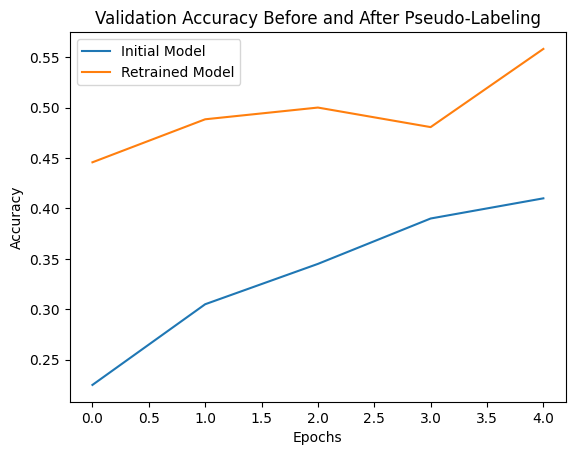

In [ ]:
# Plot validation accuracy before and after pseudo-labeling
plt.plot(history.history['val_accuracy'], label='Initial Model')
plt.plot(history_retrained.history['val_accuracy'], label='Retrained Model')
plt.title('Validation Accuracy Before and After Pseudo-Labeling')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

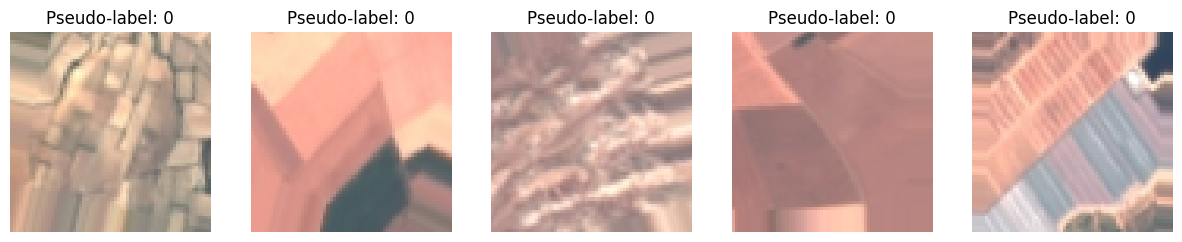

In [ ]:
# Display pseudo-labeled data samples if available
if len(X_pseudo) > 0:
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(X_pseudo[i])
        ax.set_title(f"Pseudo-label: {y_pseudo[i]}")
        ax.axis('off')
    plt.show()
else:
    print("No pseudo-labeled data to display.")
